---
**Introduction to Numerical Shooting**

Week 15 of EMAT30008

https://engmaths.github.io/emat30008/odes/numericalshooting/ 

(See week15funcs.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from scipy.optimize import root

# Move to parent directory, then w14, import, change back
# TODO: make this importing less hard coded to folder names
os.chdir(os.path.pardir)
os.chdir("Week 14")
from week14funcs import euler_step, solve_to 
os.chdir(os.path.pardir)
os.chdir("Week 15")


-------
*Simulating Predator Prey Equations*

$ \frac{dx}{dt} = x(1-x) - \frac{axy}{d+x} $

$ \frac{dy}{dt} = by(1 - \frac{y}{x}) $

set a = 1, d = 0.1, b $\in [0.1,0.5]$

We'll choose x=1,y=1 as initial conditions

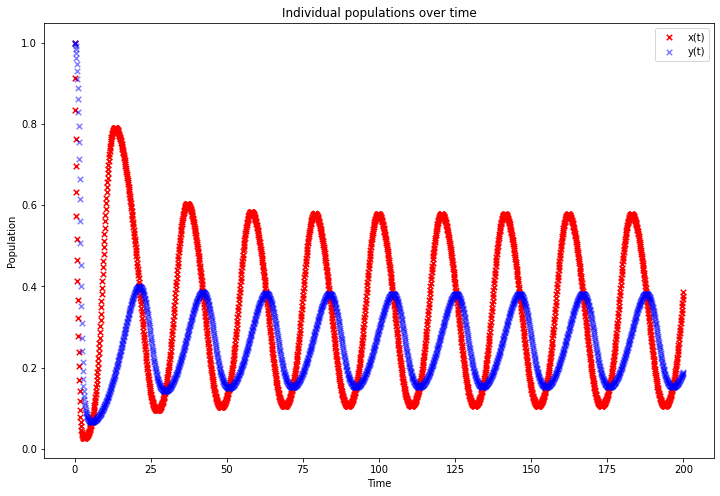

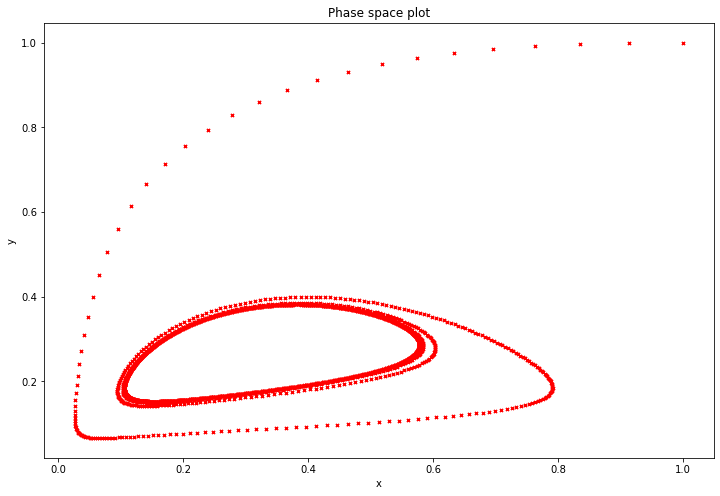

In [24]:
# Define ODE function f(x,t)
def predator_prey(x: np.ndarray, t: float):
    '''
    Defines RHS for Predator Prey system
    '''
    # Define constants inside function for now
    a = 1
    d = 0.1
    b = 0.2

    dxdt = x[0]*(1-x[0]) - (a*x[0]*x[1])/(d+x[0])
    dydt = b*x[1]*(1-(x[1]/x[0]))
    return np.array((dxdt, dydt))

# Calling solve_to with RK4 method
x_init = np.array((1,1))
solution = solve_to(predator_prey, x_init, 0, 200, 0.1, 'RK4')

plt.figure(figsize=[12,8])
plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
plt.legend()
plt.title("Individual populations over time")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
plt.title("Phase space plot")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

For b < 0.26 the solution converges to a stable limit cycle
For b > 0.26 the solution converges to a stable equillibrium point

We fix b = 0.20 and try to ascertain the period. We look at t>100 (halfway) when it has settled. Take the value of x,y at t=100, and look for the next time it reaches near this by some threshhold. Since this is an ODE we don't bother to take an average across multiple oscillations for period

We vary the tolerance `tol` until we see a jump in the reported period. For large `tol` this will just report the next step since it's sufficiently close, so make `tol` small enough that only the next value when it exactly matches up again works.

In [25]:
# Values at 1000th step of t
fixtime, xfix, yfix = solution[1000,:]
doneflag = 1
i = 1
tol =0.001
while doneflag:
    timeval, xval, yval = solution[1000+i,:]
    if np.sqrt((xval - xfix)**2 + (yval - yfix)**2) < tol:
        doneflag = 0
        continue
    i +=1
print(timeval)
print("Period is ", round(timeval - fixtime, 2), "seconds")
print("Starting conditions: \n Start time =", fixtime,
      "\n x =", xfix,"\n y =", yfix, "\n b = 0.2")


120.80000000000001
Period is  20.8 seconds
Starting conditions: 
 Start time = 100.0 
 x = 0.577460690300921 
 y = 0.29367636154151294 
 b = 0.2


--------
**Finding limit cycles**
We found the (almost) converged limit cycle above, but we want a way to probe the ODE function to look for existing limit cycles independent of starting condition.

A perfect periodic orbit would have the property `u0 = u(init=u0, T)`, where init are intial conditions shared by both, and T is the unknown period. So we look for a pair (u0, T) where this happens, by finding the root of function `G(u0,T) = [u0 - u(init=0,T)]`.

Here u(init=0,T) is given by our solver by finding the solution from u0 onwards and accessing the value at time t=T

Problem: there's an infinite family of solutions paramaterised by the start time / phase. We fix the phase by also requiring a 'phase condition' phi that arbitrarily fixes the phase.

---

Constant phase condition: 

Write `u(init, t)= [x , y]`. Then fix `x(t)=a` , for some `a`. This fixes one variable in place, but note if we chose an `a` that lives outside the range of x values in the limit cycle then this requirement stops us from finding a limit cycle. So constant phase condition isn't the best

Setting `phi(u0)= x(0) - a` we then just need to find the root of the stacked vector equation `[G, phi](u0)`

---

Derivative phase condition:

If we have a limit cycle, then the x(t) component is guaranteed to reach a turning point with dx/dt=0, since it needs to turn around at some point to attain its starting value that it deviates from, and we assume x is continuous. So just instead set `phi(u0) = dx/dt[0]`. Note that for second order ODEs converted into first order, we might have state variables [x, dx/dt] meaning we can simply search for the second state variable being 0, whereas for ODEs with state variables like [x, y] we access the derivative dx/dt from the ODE statement.

---

So to find a limit cycle we want to find a cycle starting on init condition u0=[x0, y0], with period T, where dx/dt[0] = 0.

We do this by finding a root [u0, T] to [G(u0,T), phi(u0)]: a n+1 dimensional vector valued function. We have to investigate optimisation algorithms that will search the space of parameters [u0, T] and locate a route. We might make the assumption that the functions G, phi will be smooth with respect to these parameters, so that gradient based methods can work. 

True
[0.27015621 0.27015621 0.6077888 ]


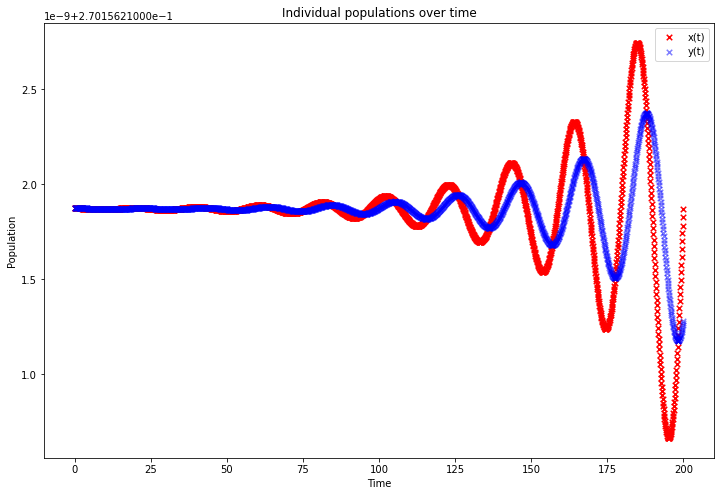

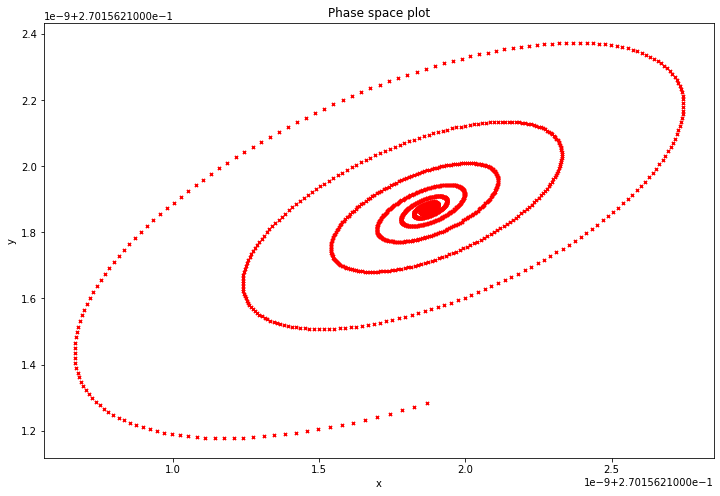

In [36]:
# We define the G,phi function to extract the root from

def limit_cycle_condition(params: np.ndarray):
    ''' 
    Defines the function [G(u0,T),phi(u0)] specified above
    '''
    # Extract u0, T
    u0, T = params[0:2], params[2]

    # Compute G by calling the solver to solve until time T
    solution = solve_to(f=predator_prey, x_init=u0, t_init=0, 
                        t_final=T, deltat_max=0.1, method='RK4')
    uT = solution[-1,1:]
    G = u0 - uT
    # Compute phi by calling the ODE function at time 0 with u0
    u0dot = predator_prey(u0, 0)
    phi = u0dot[0]

    # TODO: generalise this to take any function def
    return np.append(G,[phi])

# TODO: compare root finding
# Scipi optimise root finding uses 'modification of Powell hybrid method' 
# Returns OptimizeResult object with attributes

result = root(limit_cycle_condition, np.array([1,1,1]))
result.keys()
# Check if successful
print(result.success)
best_params = result.x
print(best_params)

# Verify against periodic orbit found

x_init = best_params[0:2]
solution = solve_to(predator_prey, x_init, 0, 200, 0.1, 'RK4')

plt.figure(figsize=[12,8])
plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
plt.legend()
plt.title("Individual populations over time")
plt.xlabel("Time")
plt.ylabel("Population")
plt.show()

plt.figure(figsize=[12,8])
plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
plt.title("Phase space plot")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


When we set initial parameter guesses to x=0.6, y=0.2, T=20, scipy root finds the stable orbit, which is validated when we integrate then plot starting from this orbit.

If you were to set the guesses to x=1,y=1,T=1 you find a solution that starts on a tiny orbit which then diverges (possibly due to numerical error)